In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import torch
from pykeops.torch import LazyTensor
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# from ..src.data_utils import load_data

In [3]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from src.data_utils import load_data

In [4]:
def rbf(sigma, device, X1, X2=None):
    x1_lazy = LazyTensor(X1[:, None, :])
    if X2 is None:
        x2_lazy = LazyTensor(X1[None, :, :])
    else:
        x2_lazy = LazyTensor(X2[None, :, :])

    D = ((x1_lazy - x2_lazy) ** 2).sum(dim=2)
    K = (-D / (2 * sigma ** 2)).exp()

    identity_shape = X1.shape[0] if X2 is None else X2.shape[0]
    return K @ torch.eye(identity_shape, device=device)

def l1_laplace(sigma, device, X1, X2=None):
    x1_lazy = LazyTensor(X1[:, None, :])
    if X2 is None:
        x2_lazy = LazyTensor(X1[None, :, :])
    else:
        x2_lazy = LazyTensor(X2[None, :, :])

    D = (x1_lazy - x2_lazy).abs().sum(dim=2)
    K = (-D / sigma).exp()

    identity_shape = X1.shape[0] if X2 is None else X2.shape[0]
    return K @ torch.eye(identity_shape, device=device)

In [5]:
torch.manual_seed(0)

In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [7]:
sigma = 5120.
# delta = 0.01
lambd = 1e-3
n_components = 4000

# Load data and standardize
# X, y = load_svmlight_file("../data/cod-rna")
X, _, _, _ = load_data("homo", seed=0, device=device)
# Get 10000 random samples
indices = torch.randperm(X.shape[0])[:10000]
X = X[indices]
# X = X.toarray()
# # X = X[:5000, :] # Subsample
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X = torch.tensor(X, device=device, dtype=torch.float32)

def kernel_fn_rbf(Y1, Y2=None):
    return rbf(sigma, device, Y1, Y2)


def kernel_fn_l1_laplace(Y1, Y2=None):
    return l1_laplace(sigma, device, Y1, Y2)

In [8]:
print(indices)

tensor([36044, 73702, 76369,  ..., 40528, 84553, 24565])


### Alg. 2 from "Recursive Sampling for the Nyström Method" by Musco & Musco (2017)

In [9]:
# def rrls_nystrom2(X, kernel_fn, lambd, delta, device):
#     m, _ = X.shape
#     print(f"m ub = {192 * torch.log(1/delta)}")
#     if m <= 192 * torch.log(1 / delta):
#         return torch.eye(m, device=device)
    
#     # Sample rows of X independently, each with probability 1/2
#     S_bar = torch.bernoulli(0.5 * torch.ones(m, device=device)).bool()
#     S_bar_mat = torch.zeros(m, torch.sum(S_bar), device=device)
#     S_bar_mat[S_bar, torch.arange(torch.sum(S_bar))] = 1
#     S_til = rrls_nystrom2(X[S_bar], kernel_fn, lambd, delta / 3, device)
#     print(f"S_bar_mat.shape = {S_bar_mat.shape}")
#     print(f"S_til.shape = {S_til.shape}")
#     S_hat = S_bar_mat @ S_til # TODO(pratik): Try making this more efficient in the future

#     # Compute approximate leverage scores
#     K = kernel_fn(X)
#     S_hatT_K = S_hat.T @ K
#     C = S_hatT_K @ S_hat # TODO(pratik): optimize this -- think of it as taking the block kernel followed by column/row scaling
#     C.diagonal().add_(lambd)
#     L = torch.linalg.cholesky(C)
#     nys_sqrt = torch.linalg.solve_triangular(L, S_hatT_K, upper=False)

#     l_tilde = 3/(2 * lambd) * (torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))
#     print(f"min of unscaled leverage scores = {torch.min(torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))}")
#     print(f"max of unscaled leverage scores = {torch.max(torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))}")
#     adj_factor = torch.log(torch.sum(l_tilde) / delta)
#     print(
#         f"min of adjusted leverage scores = {torch.min(adj_factor * l_tilde)}")
#     p = torch.minimum(torch.ones(m, device=device), adj_factor * l_tilde)
#     # print(f"min of adjusted leverage scores = {torch.min(16 * adj_factor * l_tilde)}")
#     # p = torch.minimum(torch.ones(m, device=device), 16 * adj_factor * l_tilde)

#     # Form the new sampling matrix
#     sampling_vector = torch.bernoulli(p)
#     # Find indices of sampling_vector that equal 1
#     sampling_indices = torch.nonzero(sampling_vector == 1).squeeze()
#     num_columns = sampling_indices.shape[0]
#     S = torch.zeros(m, num_columns, device=device)
#     S[sampling_indices, torch.arange(num_columns)] = 1 / torch.sqrt(p[sampling_indices])
#     return S

### Alg. 3 from "Recursive Sampling for the Nyström Method" by Musco & Musco (2017)

In [10]:
def rrls_nystrom3(X, n_components, kernel_fn, device, accelerated=False, lambd_0=0, return_leverage_scores=False):
    # TODO(pratik): Add support for accelerated version

    n_oversample = torch.log(n_components).item()
    k = torch.ceil(n_components / (4 * n_oversample)).int().item()
    n_levels = torch.ceil(torch.log2(X.shape[0] / n_components)).int().item()
    perm = torch.randperm(X.shape[0], device=device)

    # Set up sizes for recursive levels
    size_list = [X.shape[0]]
    for _ in range(n_levels):
        size_list.append(math.ceil(size_list[-1] / 2))

    # Indices of points selected at previous level of recursion
    # At the base level it's just a uniform sample of ~ n_components points
    sample = torch.arange(size_list[-1], device=device)
    indices = perm[sample]
    weights = torch.ones(indices.shape[0], device=device)

    # Compute whole diagonal of kernel matrix
    K_diag = kernel_fn(X).diagonal()

    # Main recursion, unrolled for efficiency
    for l in reversed(range(n_levels)):
        # Indices of current uniform sample
        current_indices = perm[:size_list[l]]

        # Build sampled kernel matrix
        KS = kernel_fn(X[current_indices, :], X[indices, :])
        SKS = KS[sample, :]

        # Optimal lambda for taking O(klog(k)) samples
        if k >= SKS.shape[0]:
            # For the rare chance we take less than k samples in a round
            # Don't set to exactly 0 to avoid stability issues
            lambd = 1e-5
        else:
            # Eigenvalues equal roughly the number of points per cluster, maybe this should scale with n?
            # Can be interpreted as the zoom level
            # TODO(pratik): use lobpcg to compute the top k eigenvalues
            lambd = (torch.sum(SKS.diagonal() * (weights ** 2)) 
                     - torch.sum(torch.linalg.eigvalsh(SKS * weights[:, None] * weights[None, :])[:k]))/k
        lambd = max(lambd_0 * SKS.shape[0], lambd)

        # Compute and sample by lambd ridge leverage scores
        SKS.diagonal().add_(lambd * (weights ** (-2)))
        R = torch.linalg.inv(SKS) # TODO(pratik): use cholesky here
        R = KS @ R
        if l > 0:
            # max(0, .) is to avoid numerical issues, unnecessary in theory
            leverage_score = torch.minimum(torch.tensor([1.], device=device), n_oversample * (1/ lambd) * torch.relu(
                                (K_diag[current_indices] - torch.sum(R * KS, dim=1))))
            # On intermediate levels, we independently sample each column
            # by its leverage score. The sample size is n_components in expectation
            sample = torch.bernoulli(leverage_score).bool()
            sample = torch.arange(current_indices.shape[0], device=device)[sample]
            # With very low probabiltity, we could accidentally sample no
            # Columns. In this case, just take a fixed size uniform sample
            if torch.sum(sample) == 0:
                leverage_score = torch.ones(current_indices.shape[0], device=device) * n_components / current_indices.shape[0]
                sample = torch.randperm(current_indices.shape[0])[:n_components]
            weights = 1 / torch.sqrt(leverage_score[sample])
        else:
            leverage_score = torch.minimum(torch.tensor([1.], device=device), (1 / lambd) * torch.relu(
                                (K_diag[current_indices] - torch.sum(R * KS, dim=1))))
            p = leverage_score / torch.sum(leverage_score)
            sample = torch.multinomial(p, int(n_components.item()), replacement=False)
        indices = perm[sample]

    if return_leverage_scores:
        return indices, leverage_score[torch.argsort(perm)]
    else:
        return indices

### Try out RRLS methods

In [11]:
# S = rrls_nystrom2(X, kernel_fn, lambd, torch.tensor([delta], device=device), device)

In [12]:
# S

In [13]:
# S.shape

In [14]:
indices_rrls, leverage_scores_rrls = rrls_nystrom3(X, torch.tensor([n_components]), kernel_fn_l1_laplace, device, return_leverage_scores=True)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(a-b))/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,2500,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(a-b))/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,103,1) ... OK


In [15]:
# indices_rrls

In [16]:
# leverage_scores_rrls

In [17]:
# plt.hist(leverage_scores_rrls.cpu().numpy(), bins=100)

In [18]:
def nystrom(X, indices, kernel_fn, device):
    C = kernel_fn(X[indices], X[indices])
    shift = 1e-5
    C.diagonal().add_(shift) # For stability
    KS = kernel_fn(X, X[indices])

    L = torch.linalg.cholesky(C)
    nys_sqrt = torch.linalg.solve_triangular(L, KS.T, upper=False)
    _, S, VT = torch.linalg.svd(nys_sqrt, full_matrices=False)
    S = torch.max(torch.tensor([0.], device=device), S ** 2 - shift)

    return VT.T @ torch.diag(S) @ VT

In [19]:
K_rrls = nystrom(X, indices_rrls, kernel_fn_l1_laplace, device)

# Sample indices uniformly at random
indices_rand = torch.randperm(X.shape[0])[:n_components]
K_rand = nystrom(X, indices_rand, kernel_fn_l1_laplace, device)

# Full kernel matrix
K_full = kernel_fn_l1_laplace(X)
# Compute eigendecomposition of full kernel matrix
eigvals, eigvecs = torch.linalg.eigh(K_full)
eigvals_trunc = eigvals[-n_components:]
eigvecs_trunc = eigvecs[:, -n_components:]
K_lr = eigvecs_trunc @ torch.diag(eigvals_trunc) @ eigvecs_trunc.T

# Compute spectral norm of difference between approximations and K_full
rrls_err = torch.linalg.norm(K_rrls - K_full, ord=2)
rand_err = torch.linalg.norm(K_rand - K_full, ord=2)

print(f"RRLS error = {rrls_err}")
print(f"Random error = {rand_err}")

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(a-b))/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,4000,1) ... 

OK
RRLS error = 6.920652866363525
Random error = 5.972195148468018


In [20]:
print(f"K_full[0, :] = {K_full[0, :]}")

K_full[0, :] = tensor([1.0000, 0.9610, 0.9717,  ..., 0.9661, 0.9676, 0.9577], device='cuda:1')


### Compute exact leverage scores

In [21]:
def leverage_scores(K, lambd):
    L = torch.linalg.cholesky(K + lambd * torch.eye(K.shape[0], device=device))

    # L^-T L^-1 K
    L_inv_K = torch.linalg.solve_triangular(L, K, upper=False)
    LT_inv_L_inv_K = torch.linalg.solve_triangular(L.T, L_inv_K, upper=True)

    leverage_scores = torch.diagonal(LT_inv_L_inv_K)

    return leverage_scores

In [22]:
def eff_dim(K, lambd):
    eigs_K = torch.linalg.eigvalsh(K)
    return torch.sum(eigs_K / (eigs_K + lambd))

In [23]:
# K = rbf(sigma, device, X)
# L = torch.linalg.cholesky(K + lambd * torch.eye(X.shape[0], device=device))

# # L^-T L^-1 K
# L_inv_K = torch.linalg.solve_triangular(L, K, upper=False)
# LT_inv_L_inv_K = torch.linalg.solve_triangular(L.T, L_inv_K, upper=True)

# leverage_scores = torch.diagonal(LT_inv_L_inv_K)

leverage_scores_full = leverage_scores(K_full, lambd)
leverage_scores_rrls = leverage_scores(K_rrls, lambd)
leverage_scores_rand = leverage_scores(K_rand, lambd)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,   3.,
          2.,   3.,   8.,  12.,  15.,  27.,  24.,  44.,  66.,  67.,  79.,
         93., 101., 132., 123., 151., 192., 177., 238., 249., 272., 258.,
        310., 305., 270., 301., 284., 330., 310., 293., 283., 280., 261.,
        238., 227., 236., 162., 199., 193., 193., 165., 158., 147., 148.,
        135., 156., 146., 168., 135., 114., 104.,  81.,  67.,  52.,  46.,
         51.,  70.,  66.,  53.,  45.,  47.,  42.,  50.,  80.,  80.,  65.,
         70.,  62.,  49.,  31.,  21.,  17.,   8.,   6.,   3.,   9.,   9.,
         11.,  27.,  26.,  47.,  44.,  33.,  10.,   3.,   1.,   2.,  21.,
          3.]),
 array([0.33990625, 0.34649259, 0.35307896, 0.3596653 , 0.36625165,
        0.37283802, 0.37942436, 0.38601071, 0.39259708, 0.39918342,
        0.40576977, 0.41235614, 0.41894248, 0.42552882, 0.4321152 ,
        0.43870154, 0.44528788, 0.45187426, 0.4584606 , 0.46504694,
        0.47163332, 0.47821966, 0.484806  , 0.

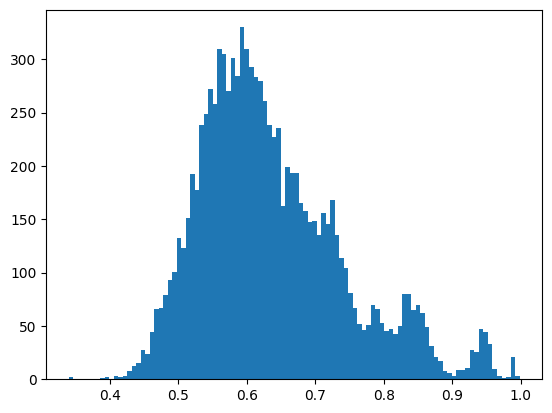

In [24]:
plt.hist(leverage_scores_full.cpu().numpy(), bins=100)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,   3.,
          2.,   3.,   8.,  12.,  15.,  27.,  24.,  44.,  66.,  67.,  79.,
         93., 101., 132., 123., 151., 192., 177., 238., 249., 272., 258.,
        310., 305., 270., 301., 284., 330., 310., 293., 283., 280., 261.,
        238., 227., 236., 162., 199., 193., 193., 165., 158., 147., 148.,
        135., 156., 146., 168., 135., 114., 104.,  81.,  67.,  52.,  46.,
         51.,  70.,  66.,  53.,  45.,  47.,  42.,  50.,  80.,  80.,  65.,
         70.,  62.,  49.,  31.,  21.,  17.,   8.,   6.,   3.,   9.,   9.,
         11.,  27.,  26.,  47.,  44.,  33.,  10.,   3.,   1.,   2.,  21.,
          3.]),
 array([5.33881175e-05, 5.44226168e-05, 5.54571161e-05, 5.64916190e-05,
        5.75261183e-05, 5.85606176e-05, 5.95951169e-05, 6.06296162e-05,
        6.16641191e-05, 6.26986148e-05, 6.37331177e-05, 6.47676134e-05,
        6.58021163e-05, 6.68366192e-05, 6.78711149e-05, 6.89056178e-05,
        6.99401135e-05, 7.0974

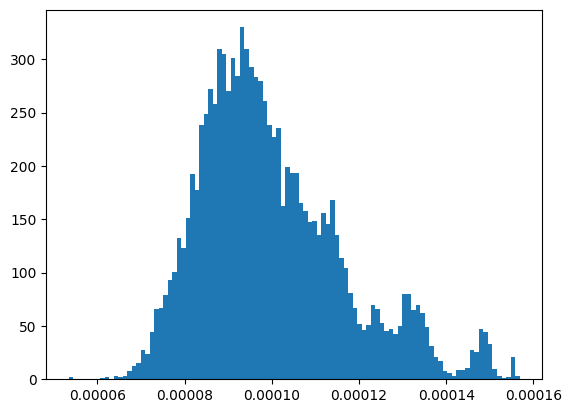

: 

In [ ]:
plt.hist(leverage_scores_full.cpu().numpy() / torch.sum(leverage_scores_full).cpu().numpy(), bins=100)

(array([  7.,  49., 122., 240., 376., 493., 608., 562., 540., 438., 370.,
        326., 280., 265., 177., 191., 124.,  94.,  71.,  82.,  91.,  78.,
         73.,  53.,  52.,  41.,  53.,  65.,  69.,  91.,  96., 101., 129.,
        149., 156., 170., 180., 176., 169., 169., 174., 139., 156., 150.,
        149., 129., 126., 110., 101., 103.,  84., 101.,  79.,  82.,  65.,
         48.,  56.,  42.,  51.,  40.,  41.,  32.,  37.,  48.,  30.,  30.,
         30.,  37.,  20.,  19.,  14.,  16.,   9.,   5.,   3.,   7.,   5.,
         10.,   7.,   7.,   7.,   3.,   3.,   6.,   0.,   1.,   2.,   2.,
          0.,   1.,   2.,   2.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.]),
 array([0.10923503, 0.11764408, 0.12605312, 0.13446218, 0.14287123,
        0.15128028, 0.15968934, 0.16809839, 0.17650744, 0.1849165 ,
        0.19332555, 0.2017346 , 0.21014366, 0.21855271, 0.22696176,
        0.23537081, 0.24377985, 0.25218892, 0.26059797, 0.26900703,
        0.27741608, 0.28582513, 0.29423419, 0.

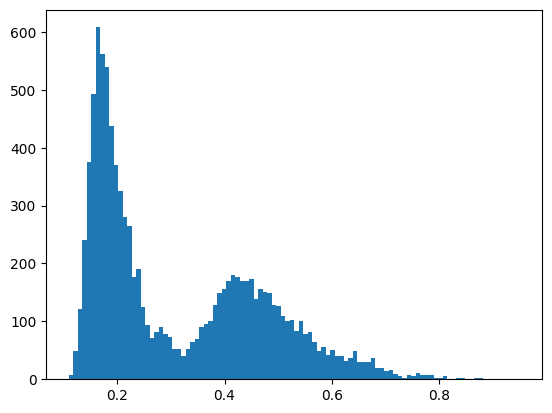

In [25]:
plt.hist(leverage_scores_rrls.cpu().numpy(), bins=100)

(array([  5.,  34., 107., 206., 356., 488., 523., 513., 532., 447., 396.,
        347., 301., 279., 192., 186., 142., 126.,  93.,  90.,  87.,  74.,
         73.,  56.,  58.,  52.,  47.,  44.,  60.,  75.,  64., 100.,  90.,
        108., 127., 157., 155., 166., 164., 182., 167., 185., 163., 173.,
        161., 144., 130., 113., 118., 122.,  89.,  86.,  90.,  96.,  69.,
         62.,  81.,  54.,  52.,  47.,  39.,  25.,  50.,  37.,  22.,  23.,
         43.,  32.,  34.,  36.,  22.,  12.,  20.,   6.,   5.,   6.,   8.,
         11.,   8.,   5.,   6.,   7.,   6.,   4.,   9.,   4.,   4.,   2.,
          4.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,
          2.]),
 array([0.10915186, 0.1172463 , 0.12534074, 0.13343517, 0.14152962,
        0.14962406, 0.15771851, 0.16581295, 0.1739074 , 0.18200183,
        0.19009627, 0.19819072, 0.20628516, 0.21437961, 0.22247405,
        0.23056848, 0.23866293, 0.24675737, 0.25485182, 0.26294625,
        0.27104071, 0.27913514, 0.2872296 , 0.

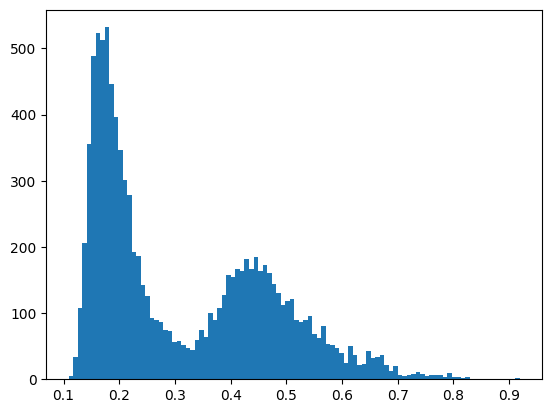

In [26]:
plt.hist(leverage_scores_rand.cpu().numpy(), bins=100)

In [27]:
eff_dim_full = eff_dim(K_full, lambd)
eff_dim_rrls = eff_dim(K_rrls, lambd)
eff_dim_rand = eff_dim(K_rand, lambd)

print(f"Effective dimension of full kernel matrix = {eff_dim_full}")
print(f"Effective dimension of RRLS approximation = {eff_dim_rrls}")
print(f"Effective dimension of random approximation = {eff_dim_rand}")

Effective dimension of full kernel matrix = 6148.53466796875
Effective dimension of RRLS approximation = 2878.0224609375
Effective dimension of random approximation = 2876.771240234375


In [28]:
print("Sum of leverage scores for full kernel matrix = ", torch.sum(leverage_scores_full))

Sum of leverage scores for full kernel matrix =  tensor(6366.7021, device='cuda:1')


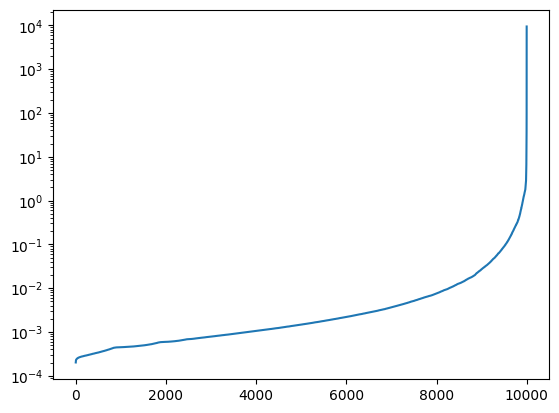

In [29]:
plt.semilogy(torch.linalg.eigvalsh(K_full).cpu().numpy())